Navier Stokes equation (using fixed point iteration)
===

Import Netgen/NGSolve Python modules:

In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
from math import log
import numpy as np
import scipy.sparse as sp
SetHeapSize(int(1e9))   

In [2]:
N = 12
T = 0.2
tau = T/N 
gamma0 = 1e-1
gamma1 = 1
gamma_dual = 1e-5
gamma_M = 1e2
maxh = 0.075
solver = "pardiso"
#solver = "umfpack"
epsilon = T/2
sample_points = np.linspace(epsilon,T,100)

#  N = [2,4,8,12,16]
# hmax = [0.4,0.2,0.1,0.075,0.05]

In [3]:
class quad_rule:
    def __init__(self,name,npoints):
        self.name = name
        self.npoints = npoints

        gauss_lobatto = {
            3: ( [ -1, 0, 1 ],
                 [ 1/3, 4/3, 1/3 ] ),
            4: ( [ -1, -np.sqrt(1/5), np.sqrt(1/5), 1],
                 [ 1/6, 5/6, 5/6, 1/6 ] ),
            5: ( [ -1, -(1/7)*np.sqrt(21),0.0, (1/7)*np.sqrt(21), 1.0 ],
                 [ 1/10,49/90,32/45, 49/90, 1/10  ] ),
            6: ( [ -1, -np.sqrt((1/21)*(7+2*np.sqrt(7))), -np.sqrt((1/21)*(7-2*np.sqrt(7))), np.sqrt((1/21)*(7-2*np.sqrt(7))), np.sqrt((1/21)*(7+2*np.sqrt(7))), 1.0 ],
                 [ 1/15, (1/30)*(14-np.sqrt(7)), (1/30)*(14+np.sqrt(7)), (1/30)*(14+np.sqrt(7)), (1/30)*(14-np.sqrt(7)),  1/15 ] ),
        }

        if name == "Gauss-Lobatto":
            self.points = gauss_lobatto[npoints][0]
            self.weights = gauss_lobatto[npoints][1]
        
    def current_pts(self,a,b):
        if self.name == "Gauss-Radau" or self.name == "Gauss" or self.name == "Gauss-Lobatto":
            return [0.5*(b-a) * pt + 0.5*(b+a)  for pt in self.points]
    
    def t_weights(self,delta_t):
        if self.name == "Gauss-Radau" or self.name == "Gauss" or self.name == "Gauss-Lobatto":
            return [0.5*delta_t*w for w in self.weights]

In [4]:
qr = quad_rule("Gauss-Lobatto",5)

The unit_square is a predefined domain, use Netgen to generate a mesh:

In [5]:
def freedofs_converter(fd):
    frees = [] 
    for i in range(len(fd)):
        if fd[i]:
            frees.append(i)
    return frees

def cond_est(a,frees):
    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    A_red = A.todense()[frees,:][:,frees] 
    return np.linalg.cond(A_red)

In [6]:
def GetMeshDataAllAround(maxh):
    geo = SplineGeometry()
    # data domain
    p1 = geo.AppendPoint (0,0)
    p2 = geo.AppendPoint (1,0)
    p4 = geo.AppendPoint (0.75,0.75)
    p5 = geo.AppendPoint (0.75,0.25)
    p6 = geo.AppendPoint (0.25,0.25)
    p7 = geo.AppendPoint (0.25,0.75)
    p11 = geo.AppendPoint(1.0,1.0)
    p12 = geo.AppendPoint(0.0,1.0)
    # omega
    geo.Append (["line", p1, p2], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p2, p11], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p11, p12], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p12, p1], leftdomain=1, rightdomain=0,bc="bc_Omega")
    # only_B
    geo.Append (["line", p6, p5], leftdomain=2, rightdomain=1)
    geo.Append (["line", p5, p4], leftdomain=2, rightdomain=1)
    geo.Append (["line", p4, p7], leftdomain=2, rightdomain=1)
    geo.Append (["line", p7, p6], leftdomain=2, rightdomain=1)
    geo.SetMaterial(1, "omega")
    geo.SetMaterial(2, "only_B")
    return geo.GenerateMesh(maxh=maxh)

In [7]:
def GetMeshDataLeft(maxh):
    geo = SplineGeometry()
    p1 = geo.AppendPoint (0,0)
    p2 = geo.AppendPoint (0.25,0)
    p3 = geo.AppendPoint (0.25,1)
    p4 = geo.AppendPoint (0,1)
    p5 = geo.AppendPoint (1,0)
    p6 = geo.AppendPoint (1,1)
    # omega 
    geo.Append (["line", p1, p2], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p2, p3], leftdomain=1, rightdomain=2)
    geo.Append (["line", p3, p4], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p4, p1], leftdomain=1, rightdomain=0,bc="bc_Omega")
    # only_B 
    geo.Append (["line", p2, p5], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p5, p6], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p6, p3], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.SetMaterial(1, "omega")
    geo.SetMaterial(2, "only_B")
    return geo.GenerateMesh(maxh=maxh)

In [8]:
#mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
mesh = Mesh(GetMeshDataAllAround(maxh) )
# mesh = Mesh(GetMeshDataLeft(maxh))
h = specialcf.mesh_size
n = specialcf.normal(2)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [9]:
t = Parameter(0.0)

# u_sol = CoefficientFunction( (  2*x**2*y*(2*y-1)*(x-1)**2*(y-1)*exp(-t), 
#                             -2*x*y**2*(2*x-1)*(x-1)*(y-1)**2*exp(-t) ) )
# p_sol = (2*cos(x)*sin(y) - 2*sin(1)*(1 - cos(1)))*exp(-t) 
u_sol = CoefficientFunction( (  sin(3*pi*x)**2*sin(6*pi*y)*t*exp(-t**2), 
                            -sin(3*pi*y)**2*sin(6*pi*x)*t*exp(-t**2) ) )

grad_u_sol_x = CoefficientFunction( (u_sol[0].Diff(x)  , 
                                     u_sol[0].Diff(y)) )
grad_u_sol_y = CoefficientFunction( (u_sol[1].Diff(x)  , 
                                     u_sol[1].Diff(y)) )


p_sol = sin(2*pi*x)*sin(2*pi*y)*t*exp(-t) 
#beta = CoefficientFunction( ( 1.0 , 1.0 ) )
beta_ref = u_sol 
nu = 1 
u_exact = u_sol
p_exact = p_sol
rhs = CoefficientFunction(( u_exact[0].Diff(t) + (u_exact[0]*u_exact[0].Diff(x) + u_exact[1]*u_exact[0].Diff(y)) 
                           - nu* ( u_exact[0].Diff(x).Diff(x) + u_exact[0].Diff(y).Diff(y) ) +  p_exact.Diff(x) ,
                           u_exact[1].Diff(t) + (u_exact[0]*u_exact[1].Diff(x) + u_exact[1]*u_exact[1].Diff(y)) 
                           - nu* ( u_exact[1].Diff(x).Diff(x) + u_exact[1].Diff(y).Diff(y) ) +  p_exact.Diff(y)
                          ) )

Define a finite element space on that mesh. 

In [10]:
#fes = H1(mesh, order=3, dirichlet="left|right|bottom|top")
fes_NC = FESpace("nonconforming",mesh, dirichlet="bc_Omega", dgjumps = True) 
fes_lam = NumberSpace(mesh)
fes_L2 = L2(mesh, order=0)
fes_primal_vel = FESpace([fes_NC*fes_NC for i in range(N+1) ])
fes_primal_pressure = FESpace([ fes_L2 for i in range(N+1) ])
fes_dual_vel = FESpace([fes_NC*fes_NC for i in range(N) ])
fes_dual_pressure = FESpace([ fes_L2 for i in range(N) ])
fes_primal_lam = FESpace([fes_lam for i in range(N)])
fes_dual_lam = FESpace([fes_lam for i in range(N)])
X = FESpace( [fes_primal_vel, fes_primal_pressure,fes_primal_lam, fes_dual_vel, fes_dual_pressure,fes_dual_lam])
print ("X-ndof = {0}".format(X.ndof ))

X-ndof = 37924


In [11]:
u, pp, llam, zz, yyy, xxi =  X.TrialFunction()
v, qq, mmu, ww, xxx, eeta =  X.TestFunction()
#print(len(u[0]) )
#print

p = [pp[i] for i in range(len(pp)) ]
z = [None] + [zz[i] for i in range(len(zz)) ]
yy = [None] + [yyy[i] for i in range(len(yyy)) ]
lam = [None] + [llam[i] for i in range(len(llam)) ]
xi = [None] + [xxi[i] for i in range(len(xxi)) ]

q = [qq[i] for i in range(len(qq)) ]
w = [None] + [ww[i] for i in range(len(ww)) ]
xx = [None] + [xxx[i] for i in range(len(xxx)) ]
mu = [None] + [mmu[i] for i in range(len(mmu)) ]
eta = [None] + [eeta[i] for i in range(len(eeta)) ]

In [12]:
def IP(u,v,nabla=False):
    if nabla:
        return sum( [ grad(u[i])*grad(v[i]) for i in range(len(u))] )
    else:
        return sum( [u[i]*v[i] for i in range(len(u))] )

def IP_conv(u,v,beta):
    return beta[0]*grad(u[0])[0]*v[0]+beta[1]*grad(u[0])[1]*v[0]+beta[0]*grad(u[1])[0]*v[1]+beta[1]*grad(u[1])[1]*v[1]
    
def IP_ut_v(u_cur,u_prev,v):
    return sum( [ (u_cur[i] - u_prev[i] ) * v[i] for i in range(len(u_cur))] )
    #help(IP(u[0],v[0]))
def IP_mixed_stab(u_cur,u_prev,v_cur,v_prev):
    return sum( [ ( grad(u_cur[i]) - grad(u_prev[i]) ) * ( grad(v_cur[i]) - grad(v_prev[i]) )  for i in range(len(u_cur))] )

def IP_CIP(u,v):
    return sum( [ (u[i] - u[i].Other()) * (v[i] - v[i].Other()) for i in range(len(u))  ] )

def IP_jump_avg(u,v):
    return sum( [ (u[i] - u[i].Other()) * 0.5 * (v[i] + v[i].Other()) for i in range(len(u))  ] )

def IP_divu_q(u,q):
    u1_dx = grad(u[0])[0]
    u2_dy = grad(u[1])[1]
    div_u = u1_dx + u2_dy
    return div_u * q  

In [13]:
gfu = GridFunction(X)
beta_prev = GridFunction(X)
#beta_prev.vec.FV().NumPy()[:] = 1e1*np.random.rand(len( beta_prev.vec.FV().NumPy() ))[:]
beta_prev.vec.FV().NumPy()[:] = 0.0

In [14]:
def get_linear_interpolation(n,t_sample,t_n,t_nn,take_gradient=False): 
    if take_gradient:
        uhx_n = grad(gfu.components[0].components[n].components[0])
        uhy_n = grad(gfu.components[0].components[n].components[1])
        uhx_nn = grad(gfu.components[0].components[n+1].components[0])
        uhy_nn = grad(gfu.components[0].components[n+1].components[1])
    else:
        uhx_n = gfu.components[0].components[n].components[0]
        uhy_n = gfu.components[0].components[n].components[1]
        uhx_nn = gfu.components[0].components[n+1].components[0]
        uhy_nn = gfu.components[0].components[n+1].components[1]
    uhx_at_t_sample = uhx_nn * (t_sample-t_n)/tau +  uhx_n * (t_nn-t_sample  )/tau
    uhy_at_t_sample = uhy_nn * (t_sample-t_n)/tau +  uhy_n * (t_nn-t_sample  )/tau
    return uhx_at_t_sample, uhy_at_t_sample

In [15]:
def SolveOseen():
    
    a = BilinearForm(X,symmetric=False)

    # add mean value pressure constraint 
    for i in range(1,N+1):
        a += (mu[i] * p[i] + lam[i] * q[i]) * dx  
        a += (eta[i] * yy[i] + xi[i] * xx[i]) * dx 
        
    # divergence zero constraint for initial data
    a +=  IP_divu_q(u[0],q[0]) * dx 
    a +=  (-1)*IP_divu_q(v[0],p[0]) * dx 

    # A1 
    for i in range(1,N+1):
        beta = CoefficientFunction((beta_prev.components[0].components[i-1].components[0], beta_prev.components[0].components[i-1].components[1] ) ) 
        
        a += IP_ut_v(u[i],u[i-1],w[i]) * dx
        a += tau * IP(u[i],w[i],nabla=True) * dx 
        a += tau * IP_conv(u[i], w[i],beta) * dx 
        a += tau *(-1)*IP_divu_q(w[i],p[i]) * dx
        a += tau * IP_divu_q(u[i],xx[i]) * dx 
        a +=  (-1)*tau * InnerProduct(beta , n ) * IP_jump_avg(u[i],w[i]) * dx(skeleton=True)
        #a +=  tau * (0.5*IfPos(InnerProduct(beta,n),InnerProduct(beta,n),-InnerProduct(beta,n))) * IP_CIP(u[i],w[i]) * dx(skeleton=True)

    # A2 
    a += gamma0 * h**2 * IP(u[0],v[0],nabla=True) * dx
    for i in range(1,N+1):
        beta = CoefficientFunction((beta_prev.components[0].components[i-1].components[0], beta_prev.components[0].components[i-1].components[1] ) ) 
    #     a += gamma_M * tau * IP(u[i],v[i]) * dx(definedon=mesh.Materials("omega"))
        a += gamma_M * tau * IP(u[i],v[i]) * dx(definedon=mesh.Materials("only_B"))
        a += gamma1 * tau * IP_mixed_stab(u[i],u[i-1],v[i],v[i-1]) * dx 
        a +=  tau * (1/h)  * IP_CIP(u[i],v[i]) * dx(skeleton=True)
        a +=  (-1)*tau * InnerProduct(beta , n ) * IP_jump_avg(v[i],z[i]) * dx(skeleton=True)
        #a +=  tau * (0.5*IfPos(InnerProduct(beta,n),InnerProduct(beta,n),-InnerProduct(beta,n))) * IP_CIP(v[i],z[i]) * dx(skeleton=True)
        a += IP_ut_v(v[i],v[i-1],z[i]) * dx
        a += tau * IP(v[i],z[i],nabla=True) * dx 
        a += tau * IP_conv(v[i], z[i],beta) * dx 

        a += (-1)*IP_divu_q(z[i],q[i]) * dx 
        a += IP_divu_q(v[i],yy[i]) * dx
        
    f = LinearForm(X)
    for i in range(1,N+1):
        t.Set(tau*i)
        f += tau * IP(w[i],rhs,nabla=False)  * dx
        f +=  gamma_M * tau * IP(v[i],u_sol) * dx(definedon=mesh.Materials("only_B"))

    with TaskManager():
        a.Assemble()
        f.Assemble()
    
    gfu.vec.data = a.mat.Inverse(X.FreeDofs(),inverse=solver) * f.vec
    
    uhx = gfu.components[0].components[N].components[0]
    uhy = gfu.components[0].components[N].components[1]
    uh = [uhx,uhy]
    p_primal = gfu.components[1].components[N]
    p_dual = gfu.components[4].components[N-1]
    
    t.Set(tau*N)
    Draw (u_sol[0] , mesh);
    
    Draw (uhx, mesh);
    
    # compute error 
    t.Set(tau*N)
    error=sqrt(Integrate( (u_sol[0]-uhx)**2 + (u_sol[1]-uhy)**2 , mesh))
    ref_error=sqrt(Integrate( (u_sol[0])**2 + (u_sol[1])**2 , mesh))
    print ("L2-error velocity final time:", error)
    error_pressure=sqrt(Integrate( (p_sol-p_primal)**2  , mesh))
    print("L2-error pressure final time:", error_pressure)
#     print ("L2-error:", error/ref_error)
    beta_prev.vec.data = gfu.vec.data 
    
    # error computation for velocity at initial time
    t.Set(0*N)
    uhx0 = gfu.components[0].components[0].components[0]
    uhy0 = gfu.components[0].components[0].components[1]
    error0 =sqrt(Integrate( (u_sol[0]-uhx0)**2 + (u_sol[1]-uhy0)**2 , mesh))
    print ("L2-error velocity initial time:", error0)
    t.Set(tau*N)
    
    
    # measuring epsilon norm
    l2_norm_at_sample_points = [ ]
    for t_sample in sample_points:
        #print("t_sample =", t_sample)
        for nn in range(0,N):
            t_n = nn*tau
            t_nn = (nn+1)*tau
            if t_sample >= t_n and t_sample <= t_nn:
                #print("t_sample = ", t_sample)
                t.Set(t_sample)
                uhx_at_t_sample, uhy_at_t_sample = get_linear_interpolation(nn,t_sample,t_n,t_nn)
                u_error_at_sample = sqrt(Integrate( (u_sol[0]-uhx_at_t_sample)**2 + (u_sol[1]-uhy_at_t_sample)**2 , mesh))
                l2_norm_at_sample_points.append(u_error_at_sample )
    #print("l2_norm_at_sample_points =", l2_norm_at_sample_points )   
    #print("max(l2_norm_at_sample_points) = ", max(l2_norm_at_sample_points ))

    # find out in which interval is epsilon
    n_epsilon = 0
    for nn in range(0,N):
        t_n = nn*tau
        t_nn = (nn+1)*tau
        if epsilon >= t_n and epsilon <= t_nn:
            n_epsilon = nn
    #print("n_epsilon =", n_epsilon)  

    l2_norm_time_nabla = 0 
    interval_length = (n_epsilon+1)*tau - epsilon 
    t_n = n_epsilon*tau
    t_nn = (n_epsilon+1)*tau
    for tau_i,omega_i in zip(qr.current_pts(epsilon,(n_epsilon+1)*tau),qr.t_weights(interval_length)):
        t.Set(tau_i )
        grad_uhx_at_t_sample, grad_uhy_at_t_sample = get_linear_interpolation(n_epsilon, tau_i,t_n,t_nn,take_gradient=True)
        l2_norm_time_nabla += omega_i * Integrate( (grad_uhx_at_t_sample - grad_u_sol_x)*(grad_uhx_at_t_sample - grad_u_sol_x) , mesh)
        l2_norm_time_nabla += omega_i * Integrate( (grad_uhy_at_t_sample - grad_u_sol_y)*(grad_uhy_at_t_sample - grad_u_sol_y) , mesh)

    for nn in range(n_epsilon+1,N):
        t_n = nn*tau
        t_nn = (nn+1)*tau
        for tau_i,omega_i in zip(qr.current_pts(nn*tau ,(nn+1)*tau),qr.t_weights(tau)):
            #print("tau_i = ", tau_i)
            t.Set(tau_i )
            grad_uhx_at_t_sample, grad_uhy_at_t_sample = get_linear_interpolation(nn, tau_i,t_n,t_nn,take_gradient=True)
            l2_norm_time_nabla += omega_i * Integrate( (grad_uhx_at_t_sample - grad_u_sol_x)*(grad_uhx_at_t_sample - grad_u_sol_x) , mesh)
            l2_norm_time_nabla += omega_i * Integrate( (grad_uhy_at_t_sample - grad_u_sol_y)*(grad_uhy_at_t_sample - grad_u_sol_y) , mesh)
            #print(" l2_norm_time_nabla =", l2_norm_time_nabla)
            #print("  omega_i  =",  omega_i )
    l2_norm_time_nabla = sqrt(l2_norm_time_nabla)
    #print("l2_norm_time_nabla ",l2_norm_time_nabla)
    print("epsilon norm =  ", max(l2_norm_at_sample_points ) + l2_norm_time_nabla )
    eps_norm = max(l2_norm_at_sample_points ) + l2_norm_time_nabla
    
    return error,eps_norm
    

In [16]:
l2_errors = [ ]
eps_norms = [ ]
# Fixed point iteration 
maxiter = 5 
for i in range(maxiter): 
    l2err,epsn = SolveOseen()
    l2_errors.append(l2err) 
    eps_norms.append(epsn)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

L2-error velocity final time: 0.01920622093724918
L2-error pressure final time: 0.2903705551157815
L2-error velocity initial time: 0.11729055693013202
epsilon norm =   0.46896801961781


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

L2-error velocity final time: 0.01920847774949945
L2-error pressure final time: 0.29013066787909964
L2-error velocity initial time: 0.11729269812175626
epsilon norm =   0.46897736284518243


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

L2-error velocity final time: 0.019208501689745812
L2-error pressure final time: 0.29013077244999286
L2-error velocity initial time: 0.11729273875653948
epsilon norm =   0.4689775752658786


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

L2-error velocity final time: 0.019208501702685357
L2-error pressure final time: 0.29013077193101977
L2-error velocity initial time: 0.11729273876204828
epsilon norm =   0.4689775753229837


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

L2-error velocity final time: 0.01920850170278069
L2-error pressure final time: 0.29013077192686904
L2-error velocity initial time: 0.11729273876218115
epsilon norm =   0.46897757532431605


In [17]:
###################### NEW RESULTS (12.06, Janosch) ############################ 

#  N = [2,4,8,12,16]
# hmax = [0.4,0.2,0.1,0.075,0.05]
# gamma0 = 1e-1
# gamma1 = 1
# gamma_M = 1e2

#L2-error velocity final time: 0.7191348063442573
#L2-error pressure final time: 1.8400009742592833
#L2-error velocity initial time: 0.5044044503523901
#epsilon norm =   2.5787269064365215

#L2-error velocity final time: 0.1858884172620359
#L2-error pressure final time: 0.6874051162752489
#L2-error velocity initial time: 0.15772880372205822
#epsilon norm =   1.0915143481306213

#L2-error velocity final time: 0.03171480012357568
#L2-error pressure final time: 0.38896966350426115
#L2-error velocity initial time: 0.12260312715662787
#epsilon norm =   0.5562102981497427

#L2-error velocity final time: 0.01920850170278069
#L2-error pressure final time: 0.29013077192686904
#L2-error velocity initial time: 0.11729273876218115
#epsilon norm =   0.46897757532431605

#L2-error velocity final time: 0.007875683529103799
#L2-error pressure final time: 0.17234493048066524
#L2-error velocity initial time: 0.1169673552363054
#epsilon norm =   0.37287809855431164

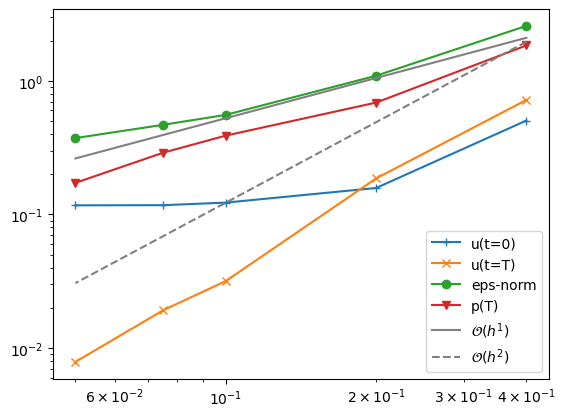

In [18]:
import numpy as np
import matplotlib.pyplot as plt

hm = [0.4,0.2,0.1,0.075,0.05]
hnp = np.array(hm)

l2_vel_initial_time = [0.5044044503523901, 0.15772880372205822, 0.12260312715662787, 0.11729273876218115,0.1169673552363054 ]
l2_vel_final_time = [0.7191348063442573,0.1858884172620359,0.03171480012357568,0.01920850170278069,0.007875683529103799 ] 
epsilon_norm = [2.5787269064365215, 1.0915143481306213, 0.5562102981497427,  0.46897757532431605, 0.37287809855431164    ] 
l2_p_final_time = [1.8400009742592833, 0.6874051162752489, 0.38896966350426115, 0.29013077192686904, 0.17234493048066524  ]
hnp = np.array(hm)
plt.loglog(hnp, l2_vel_initial_time,label="u(t=0)",marker= '+' ) 
plt.loglog(hnp, l2_vel_final_time,label="u(t=T)",marker= 'x' ) 
plt.loglog(hnp, epsilon_norm,label="eps-norm",marker= 'o' ) 
plt.loglog(hnp,l2_p_final_time,label="p(T)",marker= 'v' ) 
plt.loglog(hnp,5.25*hnp**1,label="$\mathcal{O}(h^{1})$",color='gray')
plt.loglog(hnp,12.25*hnp**2,label="$\mathcal{O}(h^{2})$",color='gray',linestyle='dashed')
plt.legend()
plt.show()
